In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from pymongo import MongoClient
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

## Connect to MongoDB - Get Spotify Data

In [2]:
client = MongoClient()
db = client.get_database('spotify')
db.list_collection_names()

['track_features', 'tracks', 'artists', 'albums', 'track_analysis']

In [3]:
cursor = db.track_features.find({}, {'_id':0, 'duration_ms':0, 'time_signature':0, 'tempo':0, 'mode':0, 'key':0})
track_features_df = pd.DataFrame(list(cursor))
track_features_df.rename(columns={'id':'spotify_song_id'},inplace=True)

## Grab the Genius Data and Merge

In [4]:
df = pd.read_pickle('../Data/topic_model_features')
df.drop('duration_ms',axis=1,inplace=True)

In [5]:
df = df.merge(track_features_df, on='spotify_song_id')
df.drop(['track_number', 'genius_song_id', 'genius_artist_id'],axis=1,inplace=True)

In [6]:
df.head(2)

,spotify_album_uri,spotify_artist_id,artist_name,spotify_artist_uri,explicit,spotify_song_id,song_title,song_spotify_page,spotify_song_uri,song_title,...,danceability,energy,instrumentalness,liveness,loudness,speechiness,track_href,type,uri,valence
0,spotify:album:4vQcWE7Ce6ORsatrqXkBtt,14H7ag1wpQOsPPQJOD6Dqr,zero,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,False,2dqpsVfEE3SWltmZ7UWb0m,i have seen,https://open.spotify.com/track/2dqpsVfEE3SWltm...,spotify:track:2dqpsVfEE3SWltmZ7UWb0m,I Have Seen,...,0.485,0.664,0.570,0.120,-8.003,0.0306,https://api.spotify.com/v1/tracks/2dqpsVfEE3SW...,audio_features,spotify:track:2dqpsVfEE3SWltmZ7UWb0m,0.742
1,spotify:album:0DJk6Y1sLiQt2ABRFaWViN,14H7ag1wpQOsPPQJOD6Dqr,zero,spotify:artist:14H7ag1wpQOsPPQJOD6Dqr,False,68lzSMOzrppH8eJpyvRpij,i have seen,https://open.spotify.com/track/68lzSMOzrppH8eJ...,spotify:track:68lzSMOzrppH8eJpyvRpij,I Have Seen,...,0.488,0.680,0.551,0.192,-8.414,0.0308,https://api.spotify.com/v1/tracks/68lzSMOzrppH...,audio_features,spotify:track:68lzSMOzrppH8eJpyvRpij,0.761


## Separate Features Columns from other data

In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [8]:
features = df.select_dtypes(include=numerics)
no_features = df.select_dtypes(exclude=numerics)

In [9]:
ss = StandardScaler()
scaled_features = ss.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features)
scaled_features.columns = features.columns
track_features_df = pd.merge(no_features, scaled_features, right_index=True, left_index=True)
track_features_df.rename(columns={'id':'spotify_song_id'},inplace=True)

## Checking Inertia

In [10]:
KMeans_df = track_features_df.select_dtypes(include=numerics)

inertia = []
i = 2
while i <= 30:
    num_clusters = i
    km = KMeans(n_clusters=num_clusters,n_jobs=-1,n_init=5)
    km.fit(KMeans_df.values)
    inertia.append(km.inertia_)
    i += 1

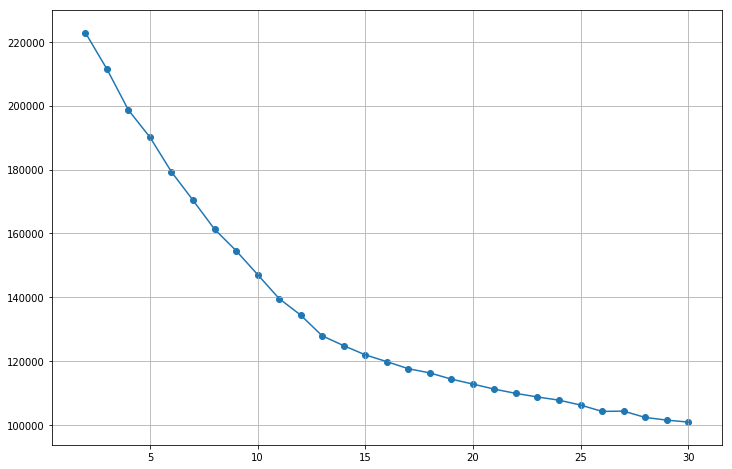

In [11]:
plt.figure(figsize=(12,8))
plt.grid()
plt.plot(range(2,31,1),inertia)
plt.scatter(range(2,31,1),inertia)

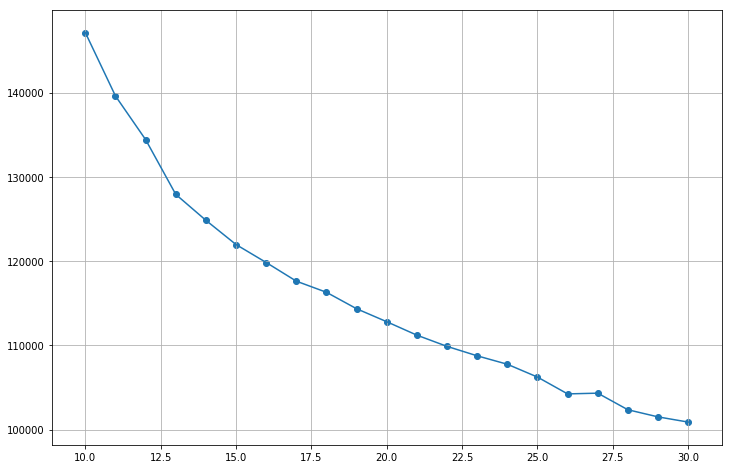

In [12]:
plt.figure(figsize=(12,8))
plt.grid()
plt.plot(range(10,31,1),inertia[8:])
plt.scatter(range(10,31,1),inertia[8:])

In [15]:
KMeans_df = df.select_dtypes(include=numerics)
num_clusters = 19
km = KMeans(n_clusters=num_clusters,n_jobs=-1,n_init=5)
km.fit(KMeans_df.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=19, n_init=5, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
KMeans_df.head()

,track_number,genius_song_id,genius_artist_id,0,1,2,3,4,5,6,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence
0,1,1465755,2570,0.026162,0.0,0.000000,0.088458,0.0,0.046422,0.0,0.00834,0.485,0.664,0.570,0.120,-8.003,0.0306,0.742
1,2,1465755,2570,0.026162,0.0,0.000000,0.088458,0.0,0.046422,0.0,0.00786,0.488,0.680,0.551,0.192,-8.414,0.0308,0.761
2,2,1465755,2570,0.026162,0.0,0.000000,0.088458,0.0,0.046422,0.0,0.00786,0.488,0.680,0.551,0.192,-8.414,0.0308,0.761
3,1,1465755,2570,0.026162,0.0,0.000000,0.088458,0.0,0.046422,0.0,0.00786,0.488,0.680,0.551,0.192,-8.414,0.0308,0.761
4,5,1040640,2570,0.020511,0.0,0.060999,0.000000,0.0,0.000000,0.0,0.51800,0.331,0.412,0.230,0.131,-8.576,0.0284,0.246


In [17]:
cluster_centroid = pd.DataFrame(km.cluster_centers_[8])

In [18]:
df.reset_index(inplace=True,drop=True)

In [108]:
recommender(df,cluster_centroid,n_recommendations=20)

(array(['https://open.spotify.com/track/4VFPW7dBZcKYB5mNfRqJCs',
        'https://open.spotify.com/track/5eeaYEPdzbtUJQmImXpMZB',
        'https://open.spotify.com/track/5AhemSBTXjZAq0duh0dMR8',
        'https://open.spotify.com/track/46BsMVyd6pfoU9TiXz4wiL',
        'https://open.spotify.com/track/31ugjl8APS8sJUS40rP0IJ',
        'https://open.spotify.com/track/5VKiGzFYVRkUkpjmLnPEEb',
        'https://open.spotify.com/track/454qJMVCWA3ssxIFIa8uju',
        'https://open.spotify.com/track/7kmgVQPFuRox26xB2sk8pE',
        'https://open.spotify.com/track/6dLZqxpT8hyFWh8hUgw0BI',
        'https://open.spotify.com/track/1KHLteiVNfWdZajsJY9ri7',
        'https://open.spotify.com/track/1WhV5UZuQGXP5WyRR1GTf2',
        'https://open.spotify.com/track/6Pxal0RorxFTZgLa6ZLbAz',
        'https://open.spotify.com/track/3bor7gq5U4vXBR1tialv9Z',
        'https://open.spotify.com/track/53ZukM4RtAPbt2YdyPiRr1',
        'https://open.spotify.com/track/3CLrvRZdnTaiQNN9pV4ZF9',
        'https://open.spo

In [77]:
df.drop('duration_ms',axis=1,inplace=True)